Loading the required libraries

In [67]:
import pandas as pd
import ast
import numpy as np
import json
import matplotlib.pyplot as plt
import re

from keras.models import load_model 
from keras.utils import pad_sequences

from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer
from ekphrasis.dicts.emoticons import emoticons

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import string
from wordcloud import WordCloud, STOPWORDS

from itertools import product

Loading the reddit data scraped in reddit_data_scrapping.ipynb

In [54]:
reddit_data = pd.read_csv('data/reddit_comment_data.csv')
reddit_data['Comments_list'] = reddit_data['Comments'].apply(ast.literal_eval)

Preparing the same text preprocessing as used in sentiment_analysis.ipynb.

In [ ]:
# recreating ekphrasis preprocessor and tokenizer set up from sentiment_analysis.ipynb
text_processor = TextPreProcessor(normalize = ['url', 'email', 'phone', 'user', 'time', 'date', 'number', 'money', 'hashtag', 'percent'],
                                  annotate = {'hashtag', 'allcaps', 'elongated', 'repeated', 'emphasis', 'censored'},
                                  fix_text = True, spell_correct_path = None, 
                                  tokenizer = SocialTokenizer(lowercase = True).tokenize, dicts = [emoticons])

social_tokenizer = SocialTokenizer(lowercase = True)

# creating a function to encode sequences
def preprocess_encode(comments_list, word_index, max_len):
    # if passed list is empty return empty
    if not comments_list:
        return np.array([]), []
    # preprocessing
    processed_text_list = [" ".join(text_processor.pre_process_doc(str(text))) for text in comments_list]
    # tokenizing
    tokenized_list = [social_tokenizer.tokenize(x) for x in processed_text_list]
    # encoding to vectors
    int_sequences = []
    for thread in tokenized_list:
        int_sequences.append([word_index.get(word, 0) for word in thread])
    # padding the vectors
    padded_sequences = pad_sequences(int_sequences, maxlen = max_len, padding = 'post', truncating = 'post')
    # returning padded sequences and processed text
    return padded_sequences, processed_text_list

c:\Users\owenh\OneDrive\Documents\Northwestern Stuff\Academic Year 4 2025-26\01 - Fall 2025\STAT 362\STAT_362_Final_Project\.venv\Lib\site-packages\ekphrasis\classes\tokenizer.py:225: FutureWarning: Possible nested set at position 2190
  self.tok = re.compile(r"({})".format("|".join(pipeline)))


Reading english - 1grams ...
You can't omit/backoff and unpack hashtags!
 unpack_hashtags will be set to False


c:\Users\owenh\OneDrive\Documents\Northwestern Stuff\Academic Year 4 2025-26\01 - Fall 2025\STAT 362\STAT_362_Final_Project\.venv\Lib\site-packages\ekphrasis\classes\exmanager.py:14: FutureWarning: Possible nested set at position 42
  regexes = {k.lower(): re.compile(self.expressions[k]) for k, v in


Loading the trained model and tokenization dictionary from sentiment_analysis.ipynb to analyze the reddit threads.

In [8]:
# loading the dictionary and model
model = load_model('data/best_sentiment_model.keras')
with open('data/tokenization_dictionary.json', 'rb') as f:
    word_index = json.load(f)

In [51]:
# getting average sentiment for each game thread
average_sentiment_scores = []
processed_sequences = []
for comment_list in reddit_data['Comments_list']:
    # getting padded sequence
    padded_sequences, processed_sequence = preprocess_encode(comment_list, word_index, 40) # 40 limit is from sentiment_analysis.ipynb
    processed_sequences.append(processed_sequence)
    # if coments exist
    if padded_sequences.size > 0:
        # getting the sentiment probabilites
        probas = model.predict(padded_sequences, verbose = 0)
        # getting average sentiment vector for the post-game thread
        average_vector = np.mean(probas, axis = 0)
        average_sentiment_scores.append(average_vector)
    else:
        average_sentiment_scores.append(np.nan)


In [55]:
reddit_data['Average_Sentiment'] = average_sentiment_scores
new_cols = reddit_data['Average_Sentiment'].apply(pd.Series)
new_cols.columns = ['Average Negative Sentiment', 'Average Neutral Sentiment', 'Average Positive Sentiment']
reddit_data = pd.concat([reddit_data.drop('Average_Sentiment', axis = 1), new_cols], axis = 1)
reddit_data['processed_text'] = processed_sequences
reddit_data.head(3)

,Team,Comments,Game_Number,Won_This_Week,Won_Next_Week,Comments_list,Average Negative Sentiment,Average Neutral Sentiment,Average Positive Sentiment,processed_text
0,Bears,"[""Caleb wasn't good, but he didn't lose us the...",1,1,0.0,"[Caleb wasn't good, but he didn't lose us the ...",0.352189,0.447292,0.200519,"[caleb wasn ' t good , but he didn ' t lose us..."
1,Bears,['My initial reactions: The Good -The defense...,2,0,0.0,[My initial reactions: The Good -The defense....,0.375097,0.421187,0.203715,[my initial reactions : the good - the defense...
2,Bears,['I don’t like this Waldron guy. https://i.red...,3,0,1.0,[I don’t like this Waldron guy. https://i.redd...,0.366115,0.435218,0.198666,"[i don ’ t like this waldron guy . <url>, i do..."


Quick EDA of the sentiment analysis reveals little difference in analyzed sentiment between fans that won or lost the game they are analyzing nor winning or losing the following game.

In [60]:
reddit_data[['Average Negative Sentiment', 'Average Neutral Sentiment', 'Average Positive Sentiment', 'Won_Next_Week']].groupby('Won_Next_Week').mean()

,Average Negative Sentiment,Average Neutral Sentiment,Average Positive Sentiment
Won_Next_Week,,,
0.0,0.352956,0.454056,0.192988
1.0,0.350205,0.458207,0.191588


In [ ]:
reddit_data[['Average Negative Sentiment', 'Average Neutral Sentiment', 'Average Positive Sentiment', 'Won_This_Week']].groupby('Won_This_Week').mean()

,Average Negative Sentiment,Average Neutral Sentiment,Average Positive Sentiment
Won_This_Week,,,
0,0.369090,0.429532,0.201378
1,0.332341,0.486460,0.181198


Creating word maps of both groupings, won/lost this week and won/lost next week.

In [66]:
grouped_next_map = {}
for win_loss, group in reddit_data[['processed_text', 'Won_Next_Week']].groupby('Won_Next_Week'):
    flattened_text = [word for text_list in group['processed_text'].values.tolist()
                            for word in text_list]
    grouped_next_map[win_loss] = ' '.join(flattened_text)

grouped_this_map = {}
for win_loss, group in reddit_data[['processed_text', 'Won_This_Week']].groupby('Won_This_Week'):
    flattened_text = [word for text_list in group['processed_text'].values.tolist()
                            for word in text_list]
    grouped_this_map[win_loss] = ' '.join(flattened_text)

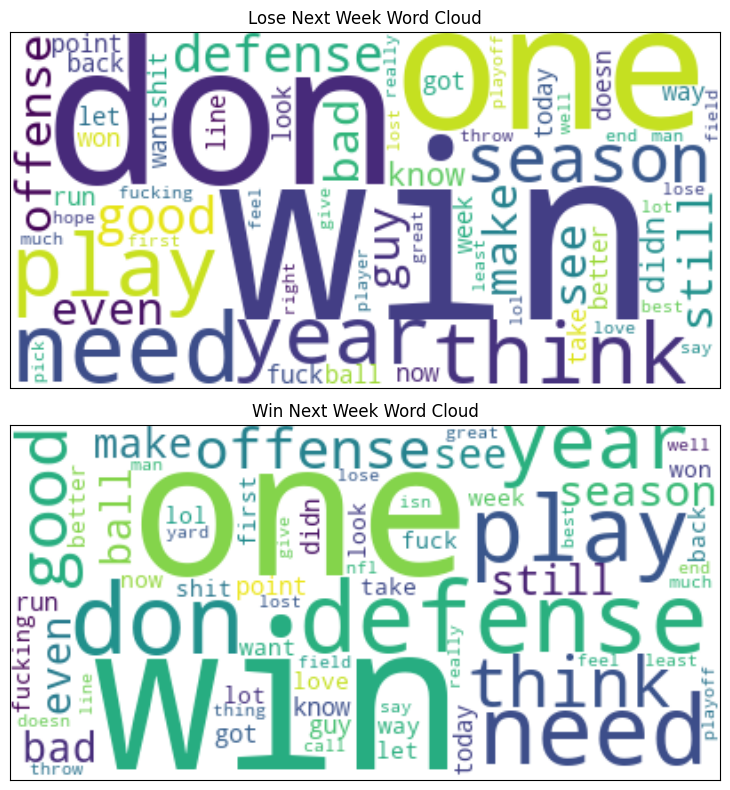

In [74]:
# setting up figure to plot the wordclouds
fig, axs = plt.subplots(2,1, figsize = (15, 8))
axs = axs.flatten()
# setting titles of each subplot
titles = {1: 'Win Next Week Word Cloud', 0: 'Lose Next Week Word Cloud'}
# going through each label type
for i, (sentiment, text) in enumerate(grouped_next_map.items()):
    # removing the same words from each processed string, mostly removing processed additions
    words_to_filter = ['<url>', '<user>', '<hashtag>', '</hashtag>', '<allcaps>', '</allcaps>', 
        '<repeated>', '</repeated>', 'number', 'time', 'date', 'money', 'percent', 'may', 'will', 'tomorrow', 'going',
        'game', 'team']
    cleaned_text = text
    for word in words_to_filter:
        cleaned_text = re.sub(re.escape(word), ' ', cleaned_text, flags = re.IGNORECASE)
    # generating custom stopwords to add to the standard, all combinations of one and two letters to account for common typos/meaningless tweet components
    custom_stopwords = set(STOPWORDS)
    letters = string.ascii_lowercase
    single_letters = list(letters)
    two_letter_combos = [''.join(p) for p in product(letters, repeat = 2)]
    custom_stopwords.update(single_letters + two_letter_combos)
    # generating the word cloud
    wordcloud = WordCloud(stopwords = custom_stopwords, max_words = 70, min_font_size = 10, background_color = 'white').generate(cleaned_text)
    # plotting the wordcloud in the appropriate subplot
    ax = axs[i]
    ax.imshow(wordcloud, interpolation = 'bilinear')
    ax.set_title(titles[sentiment])
    ax.tick_params(axis = 'x', which = 'both', bottom = False, labelbottom = False)
    ax.tick_params(axis = 'y', which = 'both', left = False, labelleft = False)
# showing the plot
plt.tight_layout()
plt.show()

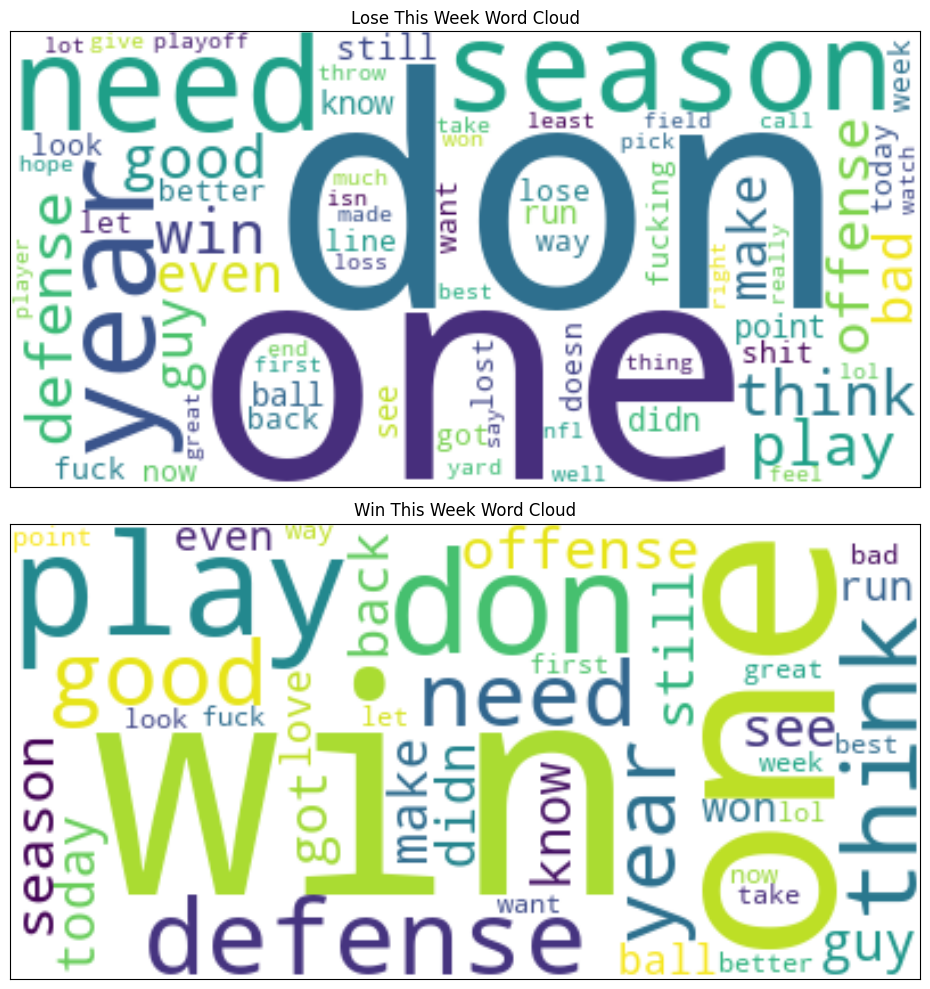

In [ ]:
# setting up figure to plot the wordclouds
fig, axs = plt.subplots(2, 1, figsize = (15, 8))
axs = axs.flatten()
# setting titles of each subplot
titles = {1: 'Win This Week Word Cloud', 0: 'Lose This Week Word Cloud'}
# going through each label type
for i, (sentiment, text) in enumerate(grouped_this_map.items()):
    # removing the same words from each processed string, mostly removing processed additions
    words_to_filter = ['<url>', '<user>', '<hashtag>', '</hashtag>', '<allcaps>', '</allcaps>', 
        '<repeated>', '</repeated>', 'number', 'time', 'date', 'money', 'percent', 'may', 'will', 'tomorrow', 'going',
        'game', 'team']
    cleaned_text = text
    for word in words_to_filter:
        cleaned_text = re.sub(re.escape(word), ' ', cleaned_text, flags = re.IGNORECASE)
    # generating custom stopwords to add to the standard, all combinations of one and two letters to account for common typos/meaningless tweet components
    custom_stopwords = set(STOPWORDS)
    letters = string.ascii_lowercase
    single_letters = list(letters)
    two_letter_combos = [''.join(p) for p in product(letters, repeat = 2)]
    custom_stopwords.update(single_letters + two_letter_combos)
    # generating the word cloud
    wordcloud = WordCloud(stopwords = custom_stopwords, max_words = 70, min_font_size = 10, background_color = 'white').generate(cleaned_text)
    # plotting the wordcloud in the appropriate subplot
    ax = axs[i]
    ax.imshow(wordcloud, interpolation = 'bilinear')
    ax.set_title(titles[sentiment])
    ax.tick_params(axis = 'x', which = 'both', bottom = False, labelbottom = False)
    ax.tick_params(axis = 'y', which = 'both', left = False, labelleft = False)
# showing the plot
plt.tight_layout()
plt.show()

The differences in the word clouds suggest there is more sentiment difference than is suggested by the sentiment analysis.

Using the sentiment analysis and/or outcome of the previous game to predict if the team will win their following game.

In [32]:
predicition_df = reddit_data[['Won_This_Week', 'Average Negative Sentiment', 'Average Neutral Sentiment', 'Average Positive Sentiment', 'Won_Next_Week']]
predicition_df = predicition_df[~predicition_df['Won_Next_Week'].isna()]
predicition_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 384 entries, 0 to 406
Data columns (total 5 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Won_This_Week               384 non-null    int64  
 1   Average Negative Sentiment  384 non-null    float32
 2   Average Neutral Sentiment   384 non-null    float32
 3   Average Positive Sentiment  384 non-null    float32
 4   Won_Next_Week               384 non-null    float64
dtypes: float32(3), float64(1), int64(1)
memory usage: 13.5 KB


In [38]:
# splitting the prediction data into X and y and getting train and test sets
X = predicition_df.drop('Won_Next_Week', axis = 1)
y = predicition_df['Won_Next_Week']

X_train_full, X_test_full, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y)

In [45]:
X_train_sentiment = X_train_full[['Average Negative Sentiment', 'Average Neutral Sentiment', 'Average Positive Sentiment']]
X_test_sentiment = X_test_full[['Average Negative Sentiment', 'Average Neutral Sentiment', 'Average Positive Sentiment']]

X_train_slr = pd.DataFrame(X_train_full['Won_This_Week'])
X_test_slr = pd.DataFrame(X_test_full['Won_This_Week'])

In [50]:
full_model = LogisticRegression(random_state = 13)
full_model.fit(X_train_full, y_train)
full_y_pred = full_model.predict(X_test_full)
full_acc = accuracy_score(y_test, full_y_pred)

sentiment_model = LogisticRegression(random_state = 13)
sentiment_model.fit(X_train_sentiment, y_train)
sentiment_y_pred = sentiment_model.predict(X_test_sentiment)
sentiment_acc = accuracy_score(y_test, sentiment_y_pred)

slr_model = LogisticRegression(random_state = 13)
slr_model.fit(X_train_slr, y_train)
slr_y_pred = slr_model.predict(X_test_slr)
slr_acc = accuracy_score(y_test, slr_y_pred)

results_df = pd.DataFrame({'Predictors': ['Both', 'Sentiment', 'W/L Previous Game'],
                           'Accuracy': [full_acc, sentiment_acc, slr_acc]})
results_df.sort_values('Accuracy', ascending = False)

,Predictors,Accuracy
0,Both,0.519481
2,W/L Previous Game,0.519481
1,Sentiment,0.441558


In [75]:
sum(y_test) / len(y_test)

0.4935064935064935

We find that the sentiment analysis conducted has failed to be predictive, being worse than chance as the odds of picking win or loss correctly is ~50%.